In [1]:
# %matplotlib inline
# 嵌入显示，就是直接在格子中显示，但现在好像不需要
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 1 生成数据集

In [2]:
# 学生版 用循环
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32) # 1000个2元组
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32) # 添加噪声

In [3]:
# 另一方法，矩阵乘法，效率更高
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w))) # randn标准正太分布，normal得指定参数
    y = torch.matmul(X, w) + b # mv也行，不过matmul好像包含mm和mv
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# torch函数处理torch类型变量，普通list不行，上面可以是因为拆开变成常数+矩阵运算
true_w = torch.tensor([2, -3.4]) 
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print(features[0], labels[0]) # 特征和结果

tensor([0.8743, 0.7512]) tensor([3.3903])


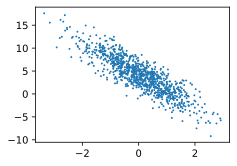

In [5]:
import matplotlib_inline.backend_inline
def use_svg_display():
    # 用矢量图显示
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
plt.show()

## 2 读取数据

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        '''
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        # feature和label都是tensor对象，有index_select方法，参数也得是tensor类型的，遂LongTensor
        yield features.index_select(0, j), labels.index_select(0, j)
        '''
        # 另一种写法，感觉更好
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10
len(features)
for X, y in data_iter(batch_size, features, labels):
    print(X,'\n', y)
    break

tensor([[-0.3689,  1.2959],
        [ 1.4848, -0.9282],
        [ 0.2194, -1.1002],
        [ 0.3117, -0.8701],
        [ 0.7978,  1.3568],
        [ 1.2424, -0.9029],
        [ 0.9768,  0.4864],
        [ 0.7636, -1.3045],
        [-0.3794, -1.8583],
        [ 1.7596, -1.5041]]) 
 tensor([[-0.9315],
        [10.3252],
        [ 8.3899],
        [ 7.7670],
        [ 1.1672],
        [ 9.7545],
        [ 4.5154],
        [10.1728],
        [ 9.7544],
        [12.8256]])


## 3 初始化模型参数

In [8]:
w = torch.normal(0, 0.01, size=(2, 1), require_grad=True, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

## 4 定义模型

In [10]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.matmul(X, w) + b

## 5 定义损失函数

In [11]:
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 6 定义优化算法

In [12]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data
        param.grad_zero_()

## 7 训练模型

In [13]:
lr = 0.03 # learning rate
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.sum().backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
    with torch.no_grad(): # 效果和用.data一样，防止w, b参数代入计算加入到计算图
        train_l = loss(net(features, w, b), labels)
        print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.042734
epoch 2, loss 0.000156
epoch 3, loss 0.000047


In [14]:
print(true_w, '\n', w)
print(true_b, '\n', b)

tensor([ 2.0000, -3.4000]) 
 tensor([[ 2.0002],
        [-3.3993]], requires_grad=True)
4.2 
 tensor([4.1996], requires_grad=True)
